# Deep Image Prior
Harsh Agarwal, 12.08.2022

## Abstract

Deep Learning as we have mostly known it, is built of three major components - we need a Network Architecture, generally a huge dataset and a robust Learning Procedure. Now, the basic idea presented by the paper Deep Image Prior is a slightly different approach to it.They propose that it is possible to perform multiple image restoration techniques, such as inpainting, restoration, super-resolution et cetera, without any explicit training with some huge training set.

## 1. Introduction

Generally, Deep Learning models approach the problem as a whole and try to build and train a model that solves it altogether. Let's say we target an image inpainting problem, in that case, we would build a model to perform inpainting on any image. Whereas, Deep Image Prior methodology takes a different route here. The paper suggests a way where we need to train **_a network per image_** to generate image priors and ultimately perform the required restoration to the image.

A prior is all the information that we have gathered about the world. Taking an example from the real-world, let's say for a fair die, we have a probability of 1/6 for the occurence of every number from 1 to 6; this is our prior. Prior is not something we completely sure about, but rather mostly confident about. 

Coming back to our images, we assume the perfect image to be free of destortions, like noise and holes. This paper tries to exploit the priors learned by Deep Learning models, hence the name Deep Image Prior. The paper stands against the common belief that Supervised Learning with huge datasets is always the only only correct approach to learn Image Priors. They show that a simple encoder-decoder network is efficient enough to capture huge amount of image statistics, ie. Image Prior using just one distorted image.

## 2. Theory: 


### Discussing Priors

Let's consider a case where we first add noise to the image and then it is de-noised. Basically, our goal is that the restored or de-noised image should be very close to the original clean image. 


<center><img src="data/notebook/image_restoration.png" width=700 />


To solve this mathematically, the correct approach would be by maximizing a posterior distribution, where we find the best image ${x}$ given the distorted image $\hat{x}$.

<center><img src="data/notebook/argmax_img.png" width=250 />
    
We do know, that according to Bayes formula, posterior is propotional to likelihood times prior. This can be now given as:

<center><img src="data/notebook/likelihood-prior.png" width=300 />
    

Therefore, If we look at it, mathematically likelihood talks about the relationship between the corrupted and clean image. So in a way, it discusses the degradation process that is followed and tries to mathematically model it.

Thinking futher about the same, let's assume during the degradation process we add a random normally distributed noise $\epsilon$ to each image pixel. Then the likelihood term can be given as normal distribution such that:

<center><img src="data/notebook/normal_likelihood.png" width=200 />

    
Having now gotten an understanding of the prior and likelihood term, let's quickly try to think if priors are actually important when solving such a restoration problem, or can we efficiently get away with it.

Now, as we just saw, ${x*}$ is the Maximum a posterior, which is given as Likelihood times Prior. We approach this in a way, where we would initially assume that we do not need any prior. This would mean that we can assume our prior term to be a constant, that is we do not require any image specific preference.

<center><img src="data/notebook/no_prior.png" width=400 />

So we get the resultant image ${x*}$ as the maximum of likelihood. We saw that likelihood is a normal distribution in this case, hence $\hat{x}$ would be the maximum in this case, as it is the Mean. Hence, once we remove the prior information we see that the restored image is same as the noisy image.

### Learning Procedure

<center><img src="data/notebook/network.png" width=600 />

**Figure 1**: *Deep Image Prior network for Image Restoration. We begin with a random set of weights, which is updated after each iteration with the objective to minimize the data energy term. During  every iteration, a fixed input image ${z}$ (generally random noise image) is passed through the network, and we obtain an output $f_{\theta_{i}}(z)$ with the current trained parameters on the network $f_{\theta_{i}}$. The image ${x_0}$ is used to compute the task-dependent loss ${E(x_0, f_{\theta_{i}}(z))}$. The gradient of the loss term is then computed w.r.t. the weights ${\theta}$ and the parameters are then updated..*


## 3. Practice: Implementation and Experiments

In the below sections we will look into multiple image restoration problems that can be efficiently solved using Deep Image Prior Approach. In some cases we will experiment with multiple networks and see how different networks perform in solving the problem.

At the start of each section the problem and the approaches followed will be explained in detail. Briefly, the notebook is further divided into these sections:
1. Understanding if Priors Help
2. Image Inpainting with different masks
3. Image Denoising using multiple models

<!-- <div class="alert alert-block alert-info"> -->
<div class="alert alert-block alert-danger">    
<b>Note:</b> To quickly run the notebook, and visualise the results I have added a flag <code>only_visualize</code>. When set to True, the notebook will use the saved results/images and visualize them. To train the models from scratch, please set this flag as False.

If this flag is set to False, few cells where the best images are handpicked and plotted may not display the best images anymore.
</div>

In [1]:
only_visualize = True

#### Import libraries

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore')

import numpy as np
import cv2
import os
import pickle

from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *
from utils.denoising_utils import *

from skimage.metrics import peak_signal_noise_ratio as compare_psnr

In [3]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

### 3.1 Understanding if Priors Help

In this section we will try to visualise if and how priors are helpful. To get an understanding of this, we will train a network to regenerate the same provided image. 

Our hypothesis here is, if priors are really helpful for regeneration, then a good image should be generated quicker than a distorted image. This is because for a distorted image, the prior information would not directly satisfy. Hence, it should take the same network more time to get trained, to generate a distorted image.

We will consider 5 different cases here:
1. Original Image
2. Image with Bernoulli Noise
3. Image with Random Gaussian Noise
4. Image with all the pixels randomly shuffled
5. Random Bernoulli Mask Image

#### Choose figure

In [4]:
img_path  = 'data/images/kate.png'
img_pil, img_np = get_image(img_path, imsize)
img_pil = crop_image(img_pil,      dim_div_by)
img_np  = pil_to_np(img_pil)
img_var = np_to_torch(img_np).type(dtype)

#### Add Different Noises and Visualise

In [5]:
img_mask_bernoulli = get_bernoulli_mask(img_pil, 0.20)
img_mask_np = pil_to_np(img_mask_bernoulli)
img_mask_np[1] = img_mask_np[0]
img_mask_np[2] = img_mask_np[0]
img_mask_var   = np_to_torch(img_mask_np).type(dtype) 
img_masked_np = img_np * img_mask_np
img_masked_var = np_to_torch(img_masked_np).type(dtype)

sigma  = 50
sigma_ = sigma/255.
img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
img_noisy_pil = crop_image(img_noisy_pil,      dim_div_by)
img_noisy_np  = pil_to_np(img_noisy_pil)
img_noisy_var = np_to_torch(img_noisy_np).type(dtype)

img_np_hwc = np.transpose(img_np, (1,2,0)).copy()
rndImg2 = np.reshape(img_np_hwc, (img_np_hwc.shape[0] * img_np_hwc.shape[1], img_np_hwc.shape[2]))
np.random.shuffle(rndImg2)
img_shuffle_np = np.transpose(np.reshape(rndImg2, img_np_hwc.shape), (2, 0, 1))
img_shuffle_var = np_to_torch(img_shuffle_np).type(dtype)

1. Original Image
2. Image with Bernoulli Noise
3. Image with Random Gaussian Noise
4. Image with all the pixels Randomly Shuffled
5. Random Bernoulli Mask Image


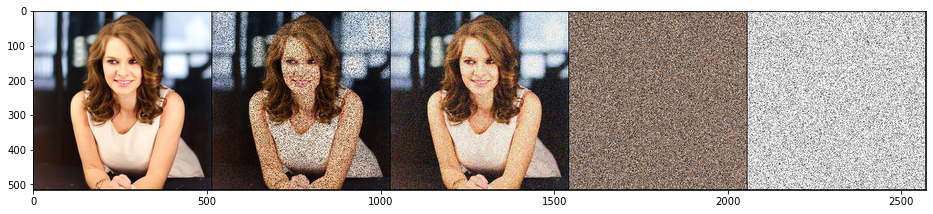

In [6]:
print("1. Original Image") 
print("2. Image with Bernoulli Noise") 
print("3. Image with Random Gaussian Noise")
print("4. Image with all the pixels Randomly Shuffled")
print("5. Random Bernoulli Mask Image")
plot_image_grid([img_np, img_masked_np, img_noisy_np, img_shuffle_np, img_mask_np], 5, 11);

In [7]:
image_generate_dict = {'original_image'  : img_var,
                       'bernoulli_image' : img_masked_var,
                       'noisy_image'     : img_noisy_var,
                       'shuffled_image'  : img_shuffle_var,
                       'random_noise'    : img_mask_var}

#### Training models on Different Images

In [8]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

# Same params and net as in super-resolution and denoising
INPUT = 'noise'
input_depth = 32
LR = 0.001 
num_iter = 5000
param_noise = False
SAVE = False
save_every = 100
log_every = 10
figsize = 5
reg_noise_std = 0.003

In [9]:
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
    out = net(net_input)
   
    total_loss = mse(out, img_used)
    total_loss.backward()
        
    if i % log_every == 0:
        if img_key not in mse_dict:
            mse_dict[img_key] = []
        mse_dict[img_key].append(total_loss.item())
        
    if SAVE and i % save_every == 0:
        out_np = torch_to_np(out)
        results_dir = os.path.join('data/generate/', img_key)
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
        cv2.imwrite(os.path.join(results_dir, str(i)+'.png'), np.transpose(out_np*255, (1,2,0))[:,:,::-1])
        
    i += 1
    return total_loss

In [10]:
if not only_visualize:

    mse_dict  = {}

    for img_key, img_used in image_generate_dict.items():
        i = 0
        # Loss
        mse = torch.nn.MSELoss().type(dtype)

        net = skip(input_depth, img_np.shape[0], 
                   num_channels_down = [128] * 5,
                   num_channels_up =   [128] * 5,
                   num_channels_skip =    [128] * 5,  
                   filter_size_up = 3, filter_size_down = 3, 
                   upsample_mode='nearest', filter_skip_size=1,
                   need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

        net = net.type(dtype)
        net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

        net_input_saved = net_input.detach().clone()
        noise = net_input.detach().clone()

        p = get_params(OPT_OVER, net, net_input)
        optimize(OPTIMIZER, p, closure, LR, num_iter)

    with open("image_generate_mse.pkl","wb") as f:
        pickle.dump(mse_dict, f)

In [11]:
with open("./image_generate_mse.pkl", "rb") as f:
    mse_dict = pickle.load(f)

#### Plotting how MSE values change for all images

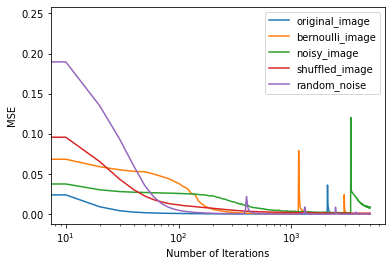

In [12]:
fig, ax = plt.subplots()
for img_key, img_mse in mse_dict.items():
    ax.plot(range(0, len(img_mse) * log_every, log_every), img_mse, label=img_key)
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('MSE')
plt.show()

<div class="alert alert-block alert-info">
<b>Outcome:</b> 

- As we see in the above plot, original image converges quickly
- The two noisy images with Bernoulli & Gaussian Noise start with relatively smaller loss function than random images and then quickly converges
- Amongst the two random noise images, the shuffled image converges more quickly than the random noise image 
</div>

### 3.2 Image Inpainting with different masks

In this section we will try to visualise the results for image inpainting using different masking techniques. 

Two masking techniques have been implemented here:
1. Using Edge Information for better sampling. Here I have added a function `get_edge_mask()` in `utils/inpainting_utils.py`. 
2. Generating random mask with percentage of pixels to keep per row. For this  I have added a function `generate_mask_by_percent()` in `utils/inpainting_utils.py`.

Here, we would first train multiple models to perform image inpainting by providing our model a masked image with randomly selected pixels, such that a very small percentage of information is retained.

From here we would select the best model, and use that model to perform inpainting on mask selected with a smarter sampling technique

#### Generating Random mask with 2% and 0.5% valid pixels in each row 

mask_random_2_percent


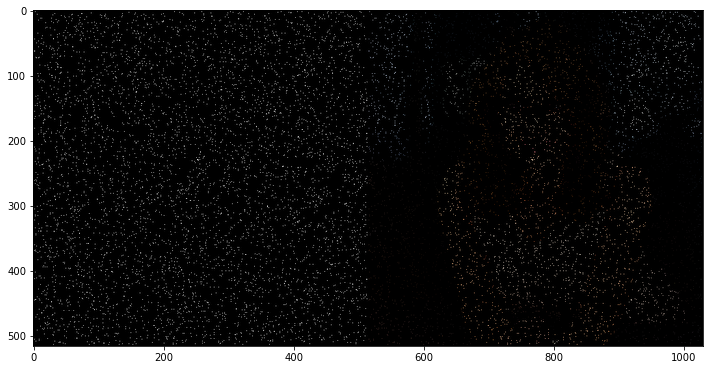

mask_random_pt_5_percent


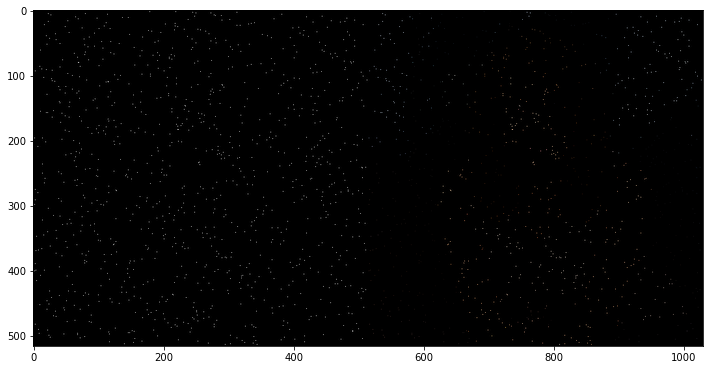

In [13]:
mask_random_2_percent = generate_mask_by_percent(img_np.shape[1:], data_percentage=2)
mask_random_pt_5_percent = generate_mask_by_percent(img_np.shape[1:], data_percentage=0.5)

random_mask_dict = {'mask_random_2_percent': mask_random_2_percent,
                    'mask_random_pt_5_percent': mask_random_pt_5_percent}

for mask_key, mask_used_np in random_mask_dict.items():
    print(mask_key)
    plot_image_grid([mask_used_np, img_np * mask_used_np], 2, 10);

In [14]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

# Same params and net as in super-resolution and denoising
INPUT = 'noise'
input_depth = 1
LR = 0.01 
num_iter = 3001
param_noise = True
SAVE = True
save_every = 100
figsize = 5
reg_noise_std = 0.00

#### Defining Multiple Models to Train

Here we compare the performance on 6 models:

0. Encoder-decoder, depth=6, without skip connections, input meshgrid
1. Encoder-decoder, depth=6, with skip connections, input meshgrid
2. Encoder-decoder, depth=6, with skip connections, input noise
3. Encoder-decoder, depth=6, without skip connections, input noise
4. U-Net Model
5. ResNet Model

In [15]:
def choose_net(net_val=0):
    if net_val == 0:
        # Encoder-decoder, depth=6, without skip connections
        INPUT = 'meshgrid'
        input_depth = 2
        LR = 0.01 
        num_iter = 5001
        param_noise = False
        reg_noise_std = 0.03
        net = skip(input_depth, img_np.shape[0], 
                   num_channels_down = [128] * 5,
                   num_channels_up   = [128] * 5,
                   num_channels_skip = [0] * 5,  
                   upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
                   need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

    elif net_val == 1:
        # Encoder-decoder, depth=6, with skip connections
        INPUT = 'meshgrid'
        input_depth = 2
        LR = 0.01 
        num_iter = 5001
        param_noise = False
        reg_noise_std = 0.03

        net = skip(input_depth, img_np.shape[0], 
                   num_channels_down = [128] * 5,
                   num_channels_up   = [128] * 5,
                   num_channels_skip = [128] * 5,  
                   upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
                   need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)


    elif net_val == 2:
        # Encoder-decoder, depth=6, with skip connections
        INPUT = 'noise'
        input_depth = 32
        LR = 0.01 
        num_iter = 6001
        param_noise = False
        reg_noise_std = 0.03
        net = skip(input_depth, img_np.shape[0], 
                   num_channels_down = [128] * 5,
                   num_channels_up =   [128] * 5,
                   num_channels_skip =    [128] * 5,
                   filter_size_up = 3, filter_size_down = 3, 
                   upsample_mode='nearest', filter_skip_size=1,
                   need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)


    elif net_val == 3:
        # Encoder-decoder, depth=6, without skip connections
        INPUT = 'noise'
        input_depth = 1
        num_iter = 3001
        reg_noise_std = 0.00
        param_noise = True
        LR = 0.01 
        net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [16, 32, 64, 128, 128, 128],
               num_channels_up =   [16, 32, 64, 128, 128, 128],
               num_channels_skip =    [0, 0, 0, 0, 0, 0],  
               filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
               upsample_mode='nearest', # downsample_mode='avg',
               need1x1_up=False,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)


    elif net_val == 4:
        # UNet model
        INPUT = 'noise'
        input_depth = 1

        num_iter = 3001
        reg_noise_std = 0.00
        LR = 0.001
        param_noise = False
        depth = int(NET_TYPE[-1])
        net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=8, more_layers=1, 
                   concat_x=False, upsample_mode='deconv', 
                   pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)


    elif net_val == 5:
        # ResNet model
        INPUT = 'noise'
        input_depth = 1

        num_iter = 3001
        show_every = 50
        figsize = 8
        reg_noise_std = 0.00
        LR = 0.001
        param_noise = False
        net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')


    else:
        assert False

    net = net.type(dtype)
    net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)
    return net, net_input, INPUT, input_depth, LR, num_iter, param_noise, reg_noise_std

In [16]:
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out * mask_used_var, img_var * mask_used_var)
    total_loss.backward()
        
    # print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  SAVE and i % save_every == 0:
        out_np = torch_to_np(out)
        results_dir = os.path.join('data/inpainting/', mask_key)
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
        cv2.imwrite(results_dir + '/out_' + str(i) + '.jpg', (np.transpose(out_np, (1, 2, 0)) * 255)[:, :, ::-1])

    i += 1

    return total_loss

In [17]:
if not only_visualize:
    for mask_key_, mask_used_np in random_mask_dict.items():
        mask_used_var = np_to_torch(mask_used_np).type(dtype)
        for net_val in range(6):
            i = 0
            net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)
            mask_key = mask_key_ + '_' + str(net_val) 
            net, net_input, INPUT, input_depth, LR, num_iter, param_noise, reg_noise_std = choose_net(net_val=net_val)
            net_input_saved = net_input.detach().clone()
            noise = net_input.detach().clone()
            p = get_params(OPT_OVER, net, net_input)
            optimize(OPTIMIZER, p, closure, LR, num_iter)

#### Plotting images with best PSNR generated from Different Models

In [18]:
def best_image_in_folder(img_gen_folder, img_np):
    best_psnr = 0
    for img_gen_name in os.listdir(img_gen_folder):
        if '.jpg' in img_gen_name or '.png' in img_gen_name:
            img_gen_pil, img_gen_np = get_image(os.path.join(img_gen_folder, img_gen_name), imsize)
            psnr_val = compare_psnr(np.transpose(img_np, (1,2,0)), np.transpose(img_gen_np, (1,2,0)))
            if psnr_val > best_psnr:
                best_psnr = psnr_val
                best_img_np = img_gen_np
                best_img_path = os.path.join(img_gen_folder, img_gen_name)
    return best_psnr, best_img_np, best_img_path

mask_random_2_percent


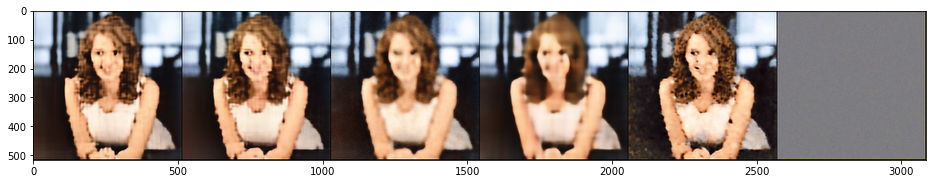

mask_random_pt_5_percent


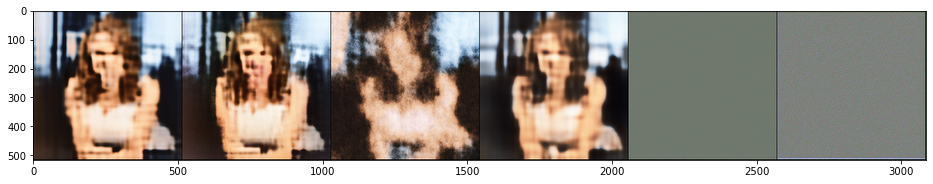

In [19]:
for mask_key_, mask_used_np in random_mask_dict.items():
    print(mask_key_)
    img_arr = [best_image_in_folder(os.path.join('data/inpainting/', mask_key_ + '_' + str(net_val)), img_np)[1] for net_val in range(6)]
    plot_image_grid(img_arr, len(img_arr), 10);

The results seem really bad when plotting the images with best PSNR in each folder. 

But when we look into the results stored in the folder we see that the results are actually much better.

Hence we can say comparing and plotting image with best PSNR is not the best practice, when we remove huge amounts of data

#### Plotting best images handpicked from Different Models

mask_random_2_percent


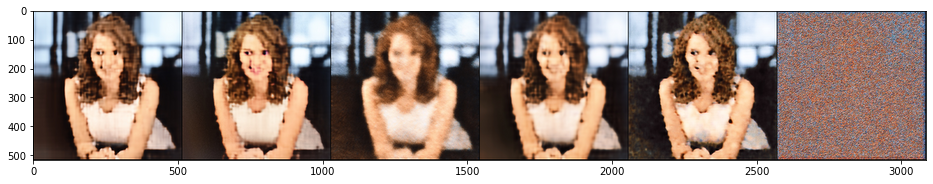

mask_random_pt_5_percent


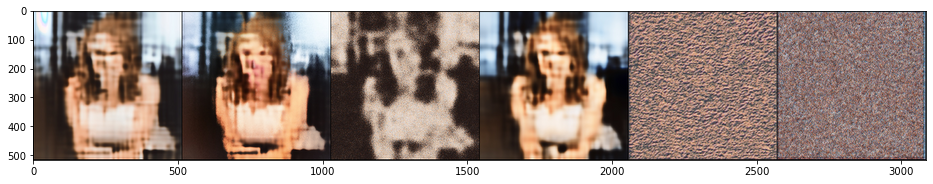

In [20]:
best_image_visualized = {'mask_random_2_percent': ['out_5000.jpg', 'out_4300.jpg', 'out_6000.jpg', 'out_2300.jpg', 'out_3000.jpg', 'out_3000.jpg'],
                         'mask_random_pt_5_percent': ['out_5000.jpg', 'out_4300.jpg', 'out_6000.jpg', 'out_2800.jpg', 'out_3000.jpg', 'out_3000.jpg']
                        }
for mask_key_, best_image_list in best_image_visualized.items():
    print(mask_key_)
    img_arr = [get_image(os.path.join(os.path.join('data/inpainting/', mask_key_ + '_' + str(net_val)), img_gen_name), imsize)[1] 
               for net_val, img_gen_name in enumerate(best_image_list)]
    plot_image_grid(img_arr, len(img_arr), 10);

<div class="alert alert-block alert-info">
<b>Outcome:</b> 

- When we keep around 2% pixels in each row
    - In the above plot we see that the network 2, 3 and 4 gives us the best results
- Whereas, when we keep around 0.5% pixels in each row
    - In the above plot we see that only network 3 gives us the best recovered image.
    
Therefore, from here it seems network 3 `(Encoder-decoder, depth=6, without skip connections)` is quite robust, and gives pretty good results even with very very less information. For further experiments in this section we will use this model.
</div>

#### Generating mask by using edge information

mask_edge


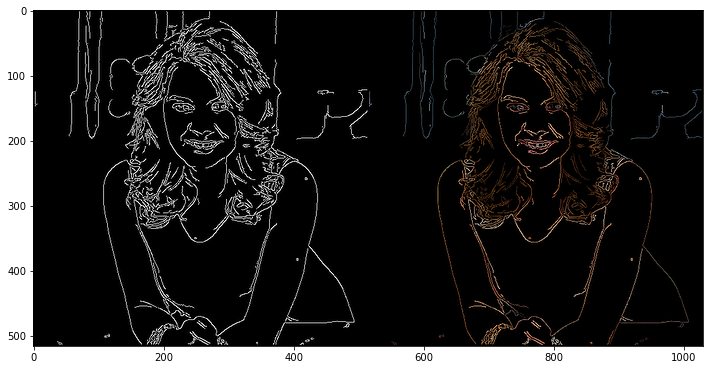

mask_edge_dilation_1


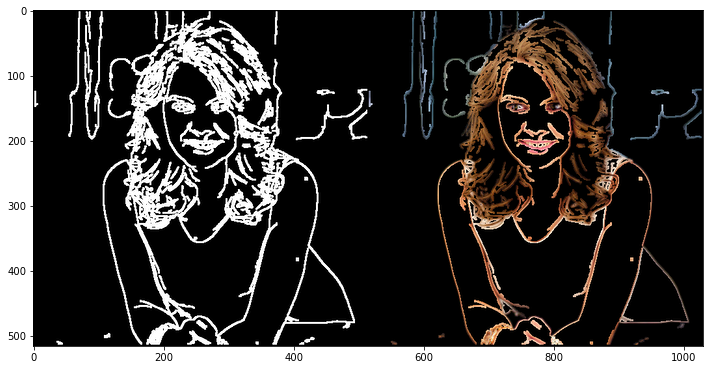

mask_edge_dilation_1_grid_8


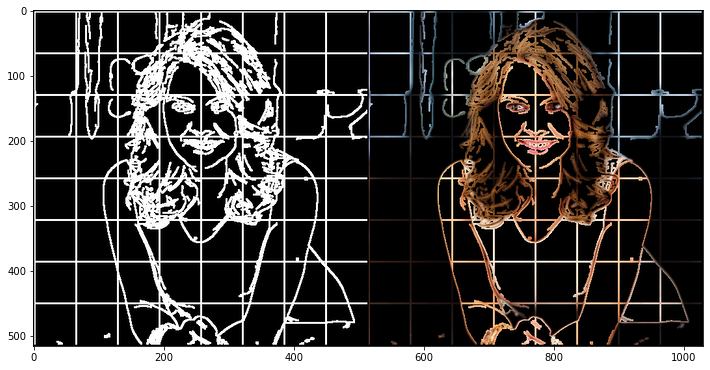

In [21]:
mask_edge = get_edge_mask(img_np)
mask_edge_dilation_1 = get_edge_mask(img_np, dilation=1)
mask_edge_dilation_1_grid_8 = get_edge_mask(img_np, dilation=1, num_grids=8)

edge_mask_dict = {'mask_edge': mask_edge,
                  'mask_edge_dilation_1': mask_edge_dilation_1,
                  'mask_edge_dilation_1_grid_8': mask_edge_dilation_1_grid_8
                 }

for mask_key, mask_used_np in edge_mask_dict.items():
    print(mask_key)
    plot_image_grid([mask_used_np, img_np * mask_used_np], 2, 10);

In [22]:
if not only_visualize:
    for mask_key, mask_used_np in edge_mask_dict.items():
        i = 0
        mask_used_var = np_to_torch(mask_used_np).type(dtype)
        INPUT = 'noise'
        # Loss
        mse = torch.nn.MSELoss().type(dtype)

        net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [16, 32, 64, 128, 128, 128],
               num_channels_up   = [16, 32, 64, 128, 128, 128],
               num_channels_skip = [0, 0, 0, 0, 0, 0],  
               filter_size_up = 3, filter_size_down = 5,  filter_skip_size=1,
               upsample_mode='nearest', # downsample_mode='avg',
               need1x1_up=False,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)


        net = net.type(dtype)
        net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)


        net_input_saved = net_input.detach().clone()
        noise = net_input.detach().clone()

        p = get_params(OPT_OVER, net, net_input)
        optimize(OPTIMIZER, p, closure, LR, num_iter)

#### Plotting best images handpicked for Different Masks

mask_edge
Percentage of valid pixels:
0.0547027587890625


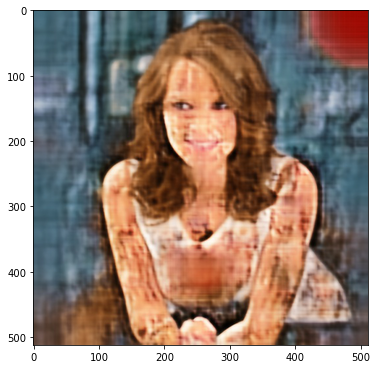

mask_edge_dilation_1
Percentage of valid pixels:
0.17104339599609375


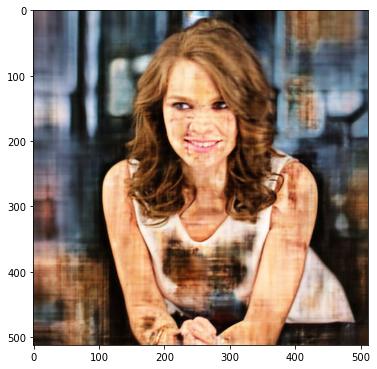

mask_edge_dilation_1_grid_8
Percentage of valid pixels:
0.24392318725585938


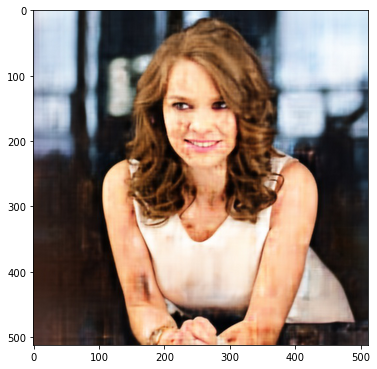

In [23]:
best_image_visualized = {'mask_edge': 'out_2900.jpg',
                         'mask_edge_dilation_1': 'out_2100.jpg', 
                         'mask_edge_dilation_1_grid_8': 'out_2100.jpg'
                        }

for mask_key_, best_img_name in best_image_visualized.items():
    print(mask_key_)
    print("Percentage of valid pixels:")
    print(np.sum(edge_mask_dict[mask_key_])/(edge_mask_dict[mask_key_].shape[1]*edge_mask_dict[mask_key_].shape[2]))
    # print(get_image(os.path.join(os.path.join('data/inpainting/', mask_key_), best_img_name), imsize)[1].shape)
    plot_image_grid([get_image(os.path.join(os.path.join('data/inpainting/', mask_key_), best_img_name), imsize)[1]], 1, 5);

<div class="alert alert-block alert-info">
<b>Outcome:</b> 

- Smarter samping gives us visually much better results, as structure information is retained now
- In portion where there is no information for large areas, we see random blobs being formed  
- Adding a thin grid throughout the image, adds some information in all areas, thereby largely improving the results 
</div>

### 3.3 Image Denoising using multiple models

In this section we will try to visualise the results for image denoising for images with noise of multiple intensities. 

Here, we would train multiple models to perform image denoising by providing our model a noisy image with varying random gaussian noise added to it.

#### Choose figure

In [24]:
fname = 'data/images/F16_GT.png'
img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_np = pil_to_np(img_pil)

#### Adding Random Gaussian Noise to Image with Varying sigma values  

sigma = 60


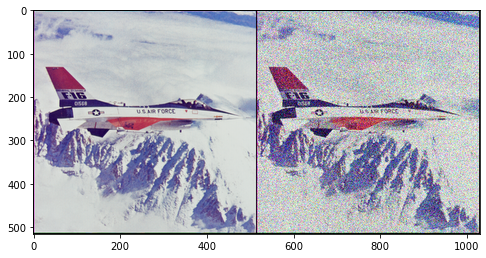

sigma = 50


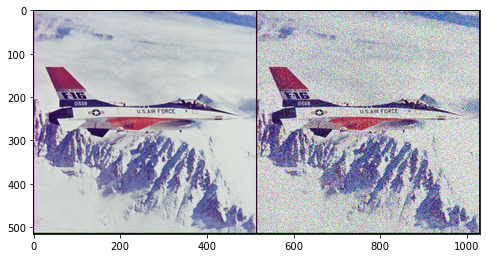

sigma = 40


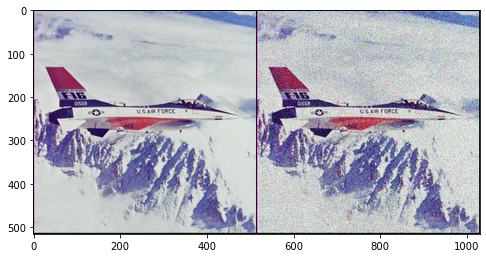

sigma = 30


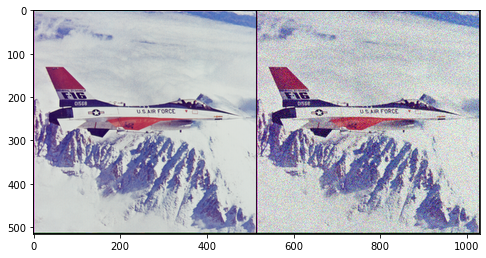

In [25]:
sigma = [60, 50, 40, 30]
img_noisy_dict = {}
for sig in sigma:
    sigma_ = sig/255.
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    img_noisy_dict['noise_sigma=' + str(sig)] = img_noisy_np
    print("sigma = " + str(sig))
    plot_image_grid([img_np, img_noisy_np], 4, 6);

In [26]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'
exp_weight=0.99

#### Defining Multiple Models to Train

Here we compare the performance on 6 models:

0. Encoder-decoder, depth=6, without skip connections, input meshgrid
1. Encoder-decoder, depth=5, with pruned skip connections, input noise
2. Encoder-decoder, depth=5, with skip connections, input noise
3. Encoder-decoder, depth=6, without skip connections, input noise

In [27]:
def choose_net(net_val=0):
    if net_val == 0:
        # Encoder-decoder, depth=6, without skip connections
        INPUT = 'meshgrid'
        input_depth = 2
        LR = 0.01 
        num_iter = 5001
        reg_noise_std = 0.03
        net = skip(input_depth, img_np.shape[0], 
                   num_channels_down = [128] * 5,
                   num_channels_up   = [128] * 5,
                   num_channels_skip = [0] * 5,  
                   upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
                   need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

    elif net_val == 1:
        # Encoder-decoder, depth=5, with pruned skip connections
        INPUT = 'noise'
        num_iter = 3000
        input_depth = 3
        reg_noise_std = 1./30. # set to 1./20. for sigma=50
        LR = 0.01
        net = skip(input_depth, 3, 
                   num_channels_down = [8, 16, 32, 64, 128], 
                   num_channels_up   = [8, 16, 32, 64, 128],
                   num_channels_skip = [0, 0, 0, 4, 4], 
                   upsample_mode='bilinear',
                   need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    elif net_val == 2:
        # Encoder-decoder, depth=5, with skip connections
        INPUT = 'noise'
        input_depth = 32
        LR = 0.01 
        num_iter = 6001
        reg_noise_std = 0.03
        net = skip(input_depth, img_np.shape[0], 
                   num_channels_down = [128] * 5,
                   num_channels_up =   [128] * 5,
                   num_channels_skip =    [128] * 5,
                   filter_size_up = 3, filter_size_down = 3, 
                   upsample_mode='nearest', filter_skip_size=1,
                   need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)


    elif net_val == 3:
        # Encoder-decoder, depth=6, without skip connections
        INPUT = 'noise'
        input_depth = 1
        num_iter = 3001
        reg_noise_std = 0.00
        LR = 0.01 
        net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [16, 32, 64, 128, 128, 128],
               num_channels_up =   [16, 32, 64, 128, 128, 128],
               num_channels_skip =    [0, 0, 0, 0, 0, 0],  
               filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
               upsample_mode='nearest', # downsample_mode='avg',
               need1x1_up=False,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)


    else:
        assert False

    net = net.type(dtype)
    net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)
    return net, net_input, INPUT, input_depth, LR, num_iter, reg_noise_std

In [28]:
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
      
    out = net(net_input)
   
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    total_loss = mse(out, img_noisy_sigma)
    total_loss.backward()
    
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    if SAVE and i % save_every == 0:
        out_np = torch_to_np(out)
        results_dir = os.path.join('data/denoising/', img_noisy_key)
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
        cv2.imwrite(results_dir + '/out_' + str(i) + '.jpg', (np.transpose(out_np, (1, 2, 0)) * 255)[:, :, ::-1])

        if psrn_noisy - psrn_noisy_last < -5: 
            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())
            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
    i += 1

    return total_loss

In [29]:
if not only_visualize:
    for img_noisy_key_, img_noisy_sigma_np in img_noisy_dict.items():
        img_noisy_sigma = np_to_torch(img_noisy_sigma_np).type(dtype)
        for net_val in range(4):
            i = 0
            mse = torch.nn.MSELoss().type(dtype)
            net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)
            img_noisy_key = img_noisy_key_ + '_' + str(net_val) 
            net, net_input, INPUT, input_depth, LR, num_iter, reg_noise_std = choose_net(net_val=net_val)
            net_input_saved = net_input.detach().clone()
            noise = net_input.detach().clone()
            out_avg = None
            last_net = None
            psrn_noisy_last = 0
            p = get_params(OPT_OVER, net, net_input)
            optimize(OPTIMIZER, p, closure, LR, num_iter)

#### Plotting images with best PSNR generated from Different Models

noise_sigma=60
Best PSNR values: [26.040001209434777, 26.256042931369166, 25.52594413966365, 25.992995739038797]


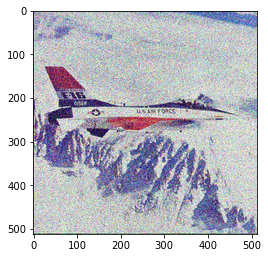

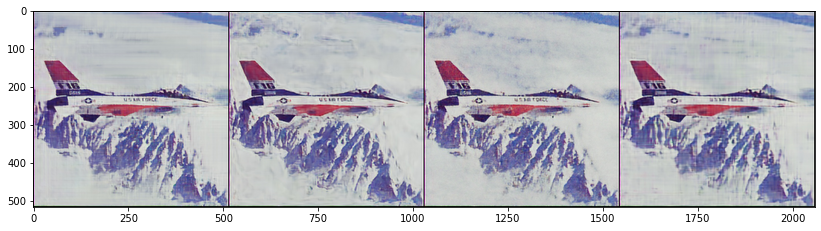

noise_sigma=50
Best PSNR values: [27.18805523767148, 27.358390890173034, 26.291794781929045, 26.92883883704646]


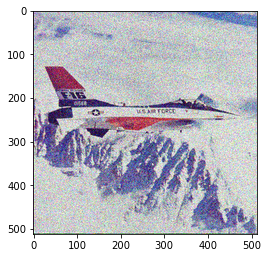

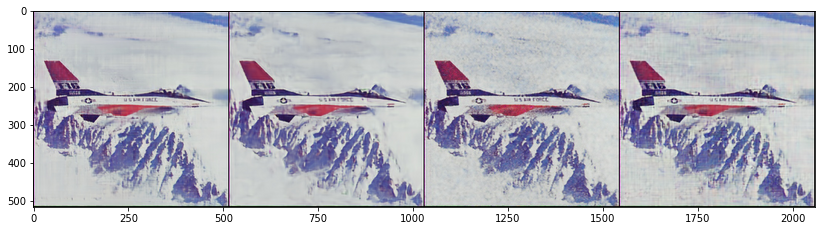

noise_sigma=40
Best PSNR values: [28.32301213060279, 28.571204531760564, 27.56502400538607, 28.414946782886386]


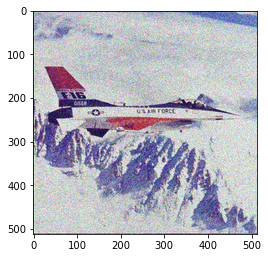

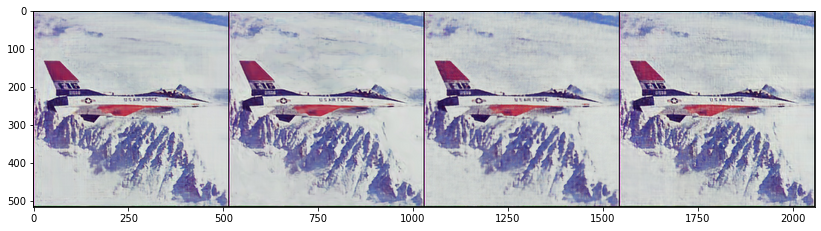

noise_sigma=30
Best PSNR values: [29.480409965775, 29.24236972433195, 28.285621640012938, 29.274299629586285]


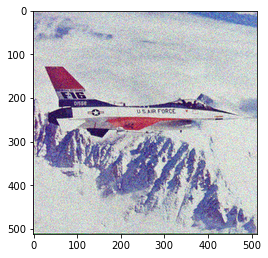

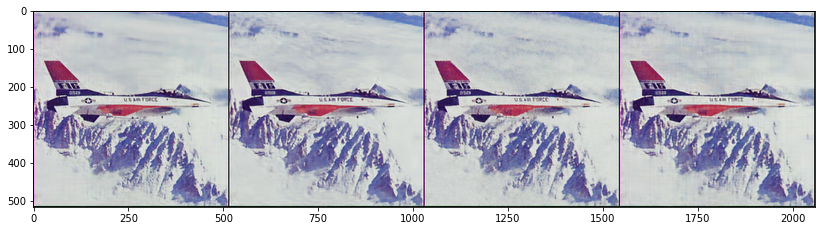

In [30]:
for img_noisy_key_, img_noisy_sigma_np in img_noisy_dict.items():
    print(img_noisy_key_)
    img_arr = [best_image_in_folder(os.path.join('data/denoising/', img_noisy_key_ + '_' + str(net_val)), img_np)[1] for net_val in range(4)]
    print("Best PSNR values: " + str([best_image_in_folder(os.path.join('data/denoising/', img_noisy_key_ + '_' + str(net_val)), img_np)[0] for net_val in range(4)]))
    plot_image_grid([img_noisy_sigma_np], 1, 3);
    plot_image_grid(img_arr, len(img_arr), 10);

<div class="alert alert-block alert-info">
<b>Outcome:</b> 

- Therefore, from here it seems network 1 - `Encoder-decoder, depth=5, with pruned skip connections` is quite robust to noise, and gives pretty good results even with a high sigma value. 
- This is different from what we saw for the inpainting model, where network 3 - `Encoder-decoder, depth=6, without skip connections` performed best.
    
</div></div>

## 4. Conclusion

Earlier, it was always assumed that only a huge dataset helps network to learn the features or priors. The paper suggests that there is no major requirement for a huge dataset in training a model. It shows the network architecture and the training procedure in itself holds capabilities to capture prior information.

One thing to note is, the author never claims this model to be State-of-the-Art model. This is the reason why in the above study we do not draw comparison with other existing models. Instead, this paper opens new research areas in Deep Learning which have not been explored earlier. This can potentially help in choosing the best model, without going through the long traditional training process.   

Just one issue in this approach is, it does not have a direct practical application. It takes thousands of iterations - both forward pass and backward propogation to perform any restortion tasks, which would not be viable in the real world use-case. Models traditionally trained with huge datasets can perform inference with only a single forward pass.

## References

[1] Ulyanov Dmitry, Andrea Vedaldi, and Victor Lempitsky. "Deep image prior." Proceedings of the IEEE conference on computer vision and pattern recognition. 2018
 
[2] Deep Image Prior [ https://dmitryulyanov.github.io/deep_image_prior ]

[3] Pratik Katte. "Demystifying - Deep Image Prior." 2019 [ https://towardsdatascience.com/demystifying-deep-image-prior-7076e777e5ba ]

[4] https://github.com/DmitryUlyanov/deep-image-prior